In [21]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix

plt.style.use('ggplot')

## Data preprocessing

### Clean tweets

In [2]:
STOPWORDS = stopwords.words('english')

In [9]:
# Read & split train test
filename = './data/clean_entire_corpus.csv'
df = pd.read_csv(filename)
df_train = df[df['source'] == 'train'].copy()
df_test = df[df['source'] == 'test'].copy()

# Remove digits
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x).strip())

# Remove stop words
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: ' '.join([w for w in x.split(' ') if w not in STOPWORDS]))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: ' '.join([w for w in x.split(' ') if w not in STOPWORDS]))

In [10]:
# Lemmatizing
lemm = WordNetLemmatizer()

def lemmatize(text):
    words = text.split(' ')
    words = [lemm.lemmatize(w) for w in words]
    words = [lemm.lemmatize(w, pos='a') for w in words]
    words = [lemm.lemmatize(w, pos='v') for w in words]
    return ' '.join(words)

df_train['text'] = df_train['text'].apply(lemmatize)
df_test['text'] = df_test['text'].apply(lemmatize)

### Vectorize tweets using TF-IDF

In [11]:
# Vectorize
tfidf = TfidfVectorizer()
data_matrix = tfidf.fit_transform(df_train.text)

X_train = data_matrix.toarray()
X_test = tfidf.transform(df_test.text).toarray()
y_train = df_train['target'].values
y_test = df_test['target'].values

## Training & Evaluating models

### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression

parameters = {'C': [10, 1, 0.1, 0.01, 0.001]}
logreg = LogisticRegression()
model = GridSearchCV(logreg, parameters, verbose=1)
model.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  4.9min finished


GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [10, 1, 0.1, 0.01, 0.001]}, verbose=1)

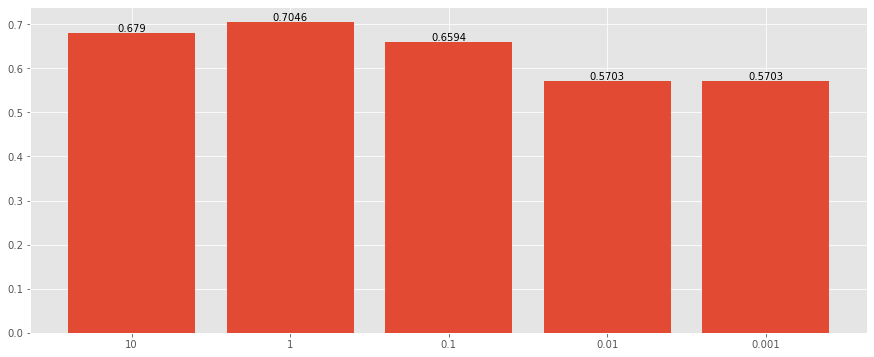

In [48]:
stats = pd.DataFrame(model.cv_results_)

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(stats['param_C'].astype(str), stats['mean_test_score'])
ax.set_xlabel('C')
ax.set_ylabel('Accuracy')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height, 4), ha='center', va='bottom')

In [31]:
def show_performance(model):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)

    print(f"Accuracy : {accuracy_score(y_test, pred)}")
    print(f"F1-score : {f1_score(y_test, pred)}")

    disp = plot_confusion_matrix(model, X_test, y_test,
                        display_labels=['0', '1'],
                        cmap=plt.cm.Blues,
                        normalize='pred')
    disp.ax_.grid(False)

Accuracy : 0.788231688630095
F1-score : 0.7363601678748569


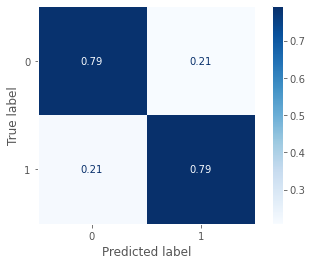

In [33]:
model = LogisticRegression(C=1.0)
    
show_performance(model)

### Multinomial Naive Bayes

In [12]:
from sklearn.naive_bayes import MultinomialNB

parameters = {'alpha': [2.0, 1.5, 1.0, 0.5, 0.01],}
model = MultinomialNB()
grid = GridSearchCV(model, parameters, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.9min finished


GridSearchCV(estimator=MultinomialNB(),
             param_grid={'alpha': [2.0, 1.5, 1.0, 0.5, 0.01]}, verbose=1)

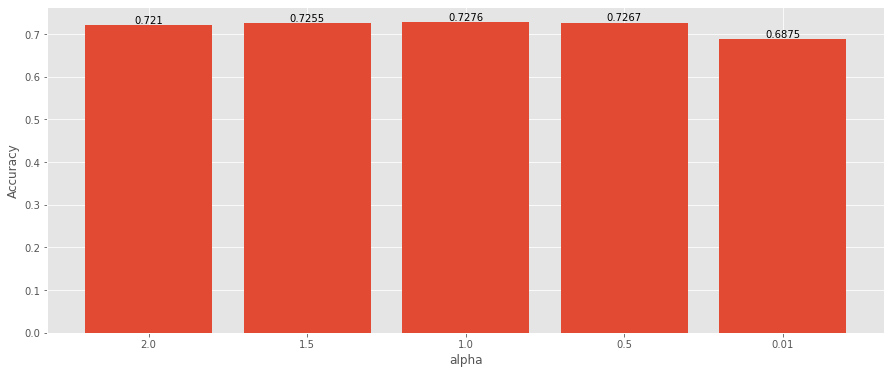

In [14]:
stats = pd.DataFrame(grid.cv_results_)

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(stats['param_alpha'].astype(str), stats['mean_test_score'])
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
for rect in bars:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, round(height, 4), ha='center', va='bottom')

Accuracy : 0.782715292675452
F1-score : 0.7007176023638666


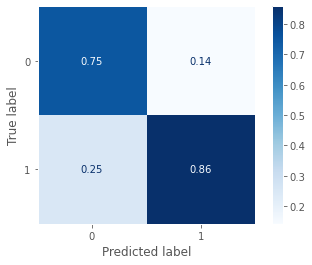

In [30]:
model = MultinomialNB(alpha=1)
show_performance(model)